In [1]:
# add quantkit to path
import sys
from pathlib import Path
d = Path().resolve().parent.parent.parent
sys.path.insert(0, str(d))

In [2]:
import quantkit.bt as bt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### YFinance

In [4]:
pip install yfinance==0.2.36

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 7.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=851634 sha256=449e1800dcbd850617082f8af4ade4b1e45088249ef2e636616b449bc2d5094a
  Stored in directory: /root/.cache/pip/wheels/06/80/9b/98db0d58349a2f5c09f8406789ade4270762f97b7d26f2fa22
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [74]:
import yfinance as yf
import matplotlib.pyplot as plt

names = ["AAPL", "TSLA"]
wts = [0.5, 0.5]
df_yf = yf.download(names, start='2018-01-01', end='2023-01-01', progress=False)["Adj Close"]
df_yf = df_yf.filter(names)

df_yf.head()

/usr/local/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/usr/local/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,AAPL,TSLA
Date,,
2018-01-02,40.615879,21.368668
2018-01-03,40.608807,21.150000
2018-01-04,40.797443,20.974667
2018-01-05,41.261932,21.105333
2018-01-08,41.108681,22.427334


In [28]:
# return
ret_data = df_yf.pct_change()[1:]
df_ret = (ret_data * wts).sum(axis=1)
df_ret = df_ret.to_frame()
df_ret.rename(columns={0: 'return'}, inplace=True)
df_ret.head()

,return
Date,
2018-01-03,-0.005204
2018-01-04,-0.001822
2018-01-05,0.008807
2018-01-08,0.029462
2018-01-09,-0.004100


In [29]:
# cumulative return
df_cret = (df_ret + 1).cumprod()
df_cret.rename(columns={'return': 'cumulative return'}, inplace=True)

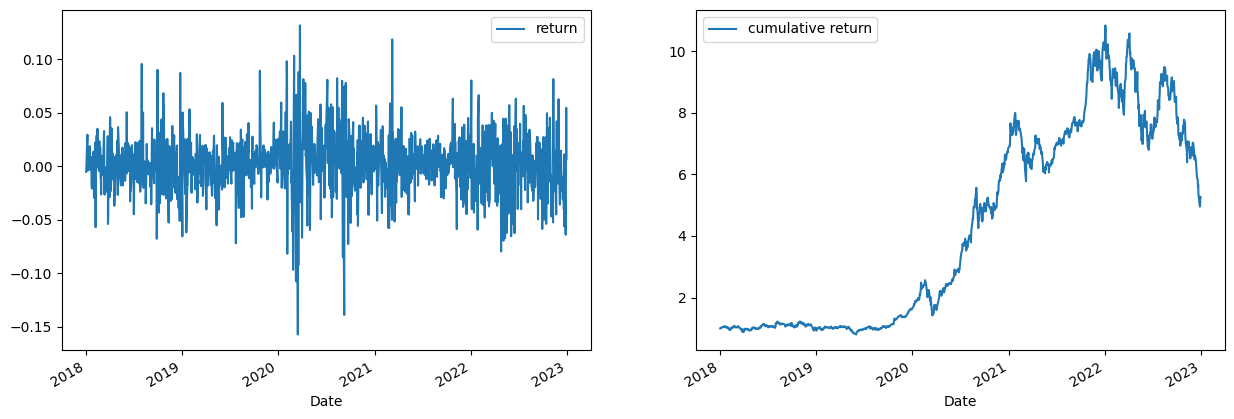

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df_ret.plot(ax=axes[0], figsize=(15, 5))
df_cret.plot(ax=axes[1], figsize=(15, 5))

plt.show()

### Quandl price data

In [96]:
import quantkit.handyman.quandl_data_loader as quandl_data_loader     
import quantkit.core.data_sources.quandl as quandl
import importlib
importlib.reload(quandl_data_loader)
importlib.reload(quandl)

df = quandl_data_loader.get_price_data(
    names,
    start_date="2018-01-01",
    end_date="2023-01-01"    
)

df.head()

2024-05-13 20:26:50,142  WORKING ON: Batch 1/1


,ticker,date,open,high,low,close,volume,closeadj,closeunadj,lastupdated
0,AAPL,2018-01-02,42.540,43.075,42.315,43.065,102223736.0,40.615,172.26,2024-05-10
1,AAPL,2018-01-03,43.133,43.638,42.990,43.057,118071596.0,40.608,172.23,2024-05-10
2,AAPL,2018-01-04,43.135,43.367,43.020,43.258,89738388.0,40.796,173.03,2024-05-10
3,AAPL,2018-01-05,43.360,43.843,43.263,43.750,94640072.0,41.261,175.00,2024-05-10
4,AAPL,2018-01-08,43.587,43.903,43.483,43.587,82271064.0,41.108,174.35,2024-05-10


In [97]:
df['ticker']

0       AAPL
1       AAPL
2       AAPL
3       AAPL
4       AAPL
        ... 
2513    TSLA
2514    TSLA
2515    TSLA
2516    TSLA
2517    TSLA
Name: ticker, Length: 2518, dtype: object

In [98]:
df['1D'] = (df['closeadj']/df.groupby('ticker')['closeadj'].shift())-1
df.head()

,ticker,date,open,high,low,close,volume,closeadj,closeunadj,lastupdated,1D
0,AAPL,2018-01-02,42.540,43.075,42.315,43.065,102223736.0,40.615,172.26,2024-05-10,NaN
1,AAPL,2018-01-03,43.133,43.638,42.990,43.057,118071596.0,40.608,172.23,2024-05-10,-0.000172
2,AAPL,2018-01-04,43.135,43.367,43.020,43.258,89738388.0,40.796,173.03,2024-05-10,0.004630
3,AAPL,2018-01-05,43.360,43.843,43.263,43.750,94640072.0,41.261,175.00,2024-05-10,0.011398
4,AAPL,2018-01-08,43.587,43.903,43.483,43.587,82271064.0,41.108,174.35,2024-05-10,-0.003708


In [99]:
df = df.pivot(index='date', columns='ticker', values='1D')
df.head()

ticker,AAPL,TSLA
date,,
2018-01-02,NaN,NaN
2018-01-03,-0.000172,-0.010248
2018-01-04,0.004630,-0.008274
2018-01-05,0.011398,0.006198
2018-01-08,-0.003708,0.062639


In [100]:
df = df[1:]
df = (df * wts).sum(axis=1)
df = df.to_frame()
df.rename(columns={0: 'return'}, inplace=True)
df.head()

,return
date,
2018-01-03,-0.005210
2018-01-04,-0.001822
2018-01-05,0.008798
2018-01-08,0.029466
2018-01-09,-0.004096


<Axes: xlabel='date'>

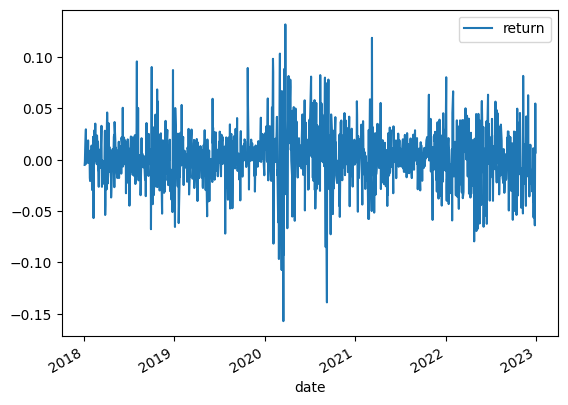

In [101]:
df.plot()

<Axes: xlabel='date'>

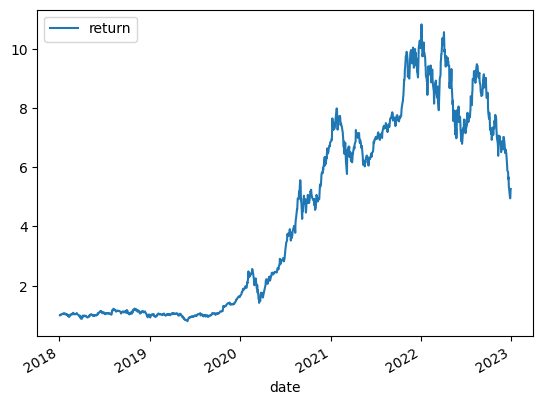

In [102]:
(df+1).cumprod(skipna=True).plot()

In [51]:
children = [ bt.Security( name ) for name in pdf.columns ]
children

[<Security foo>, <Security bar>, <Security rf>]